Тут мы воспроизведем парочку бенчмарков нашего соревнования и вдохновимся побить третий бенчмарк, а также остальных участников. Веб-формы для отправки ответов тут не будет, ориентир – [leaderboard](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard) соревнования.

In [51]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from scipy.sparse import hstack, csr_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import eli5

import warnings
warnings.filterwarnings('ignore')

### 1. Загрузка и преобразование данных
Зарегистрируйтесь на [Kaggle](www.kaggle.com), если вы не сделали этого раньше, зайдите на [страницу](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) соревнования и скачайте данные. Первым делом загрузим обучающую и тестовую выборки и посмотрим на данные.

In [33]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')

# # приведем колонки time1, ..., time10 к временному формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

# посмотрим на заголовок обучающей выборки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


В обучающей выборке содержатся следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target – целевая переменная, 1 для сессий Элис, 0 для сессий других пользователей
    
Сессии пользователей выделены таким образом, что они не могут быть длиннее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд либо когда сессия заняла по времени более 30 минут.

В таблице встречаются пропущенные значения, это значит, что сессия состоит менее, чем из 10 сайтов. Заменим пропущенные значения нулями и приведем признаки к целому типу. Также загрузим словарь сайтов и посмотрим, как он выглядит:

In [34]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# загрузим словарик сайтов
with open(r"site_dic.pkl", "rb") as input_file:
    site2id = pickle.load(input_file)
site2id['unknown'] = 0
    
# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site2id.values()), 
                          index=list(site2id.keys()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48372


,site
www.abmecatronique.com,25075
groups.live.com,13997
majeureliguefootball.wordpress.com,42436
cdt46.media.tourinsoft.eu,30911
www.hdwallpapers.eu,8104


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

### 2. Преобразуем входные данные в матрицу подсчетов токенов используя CountVectorizer

Преобразуем данные в формат, подходящий к TfidfVectorizer

In [35]:
train_df[sites].to_csv('train_text.txt', sep=' ', index=None, header=None)
test_df[sites].to_csv('test_text.txt', sep=' ', index=None, header=None)
y_train = train_df['target']

In [37]:
cv = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)

with open('train_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
    
print(X_train.shape, X_test.shape)

(253561, 50000) (82797, 50000)


In [38]:
cv.get_feature_names()[-10:]

['9980',
 '9986',
 '9989',
 '999',
 '9992',
 '9996',
 '9997',
 '9997 9997',
 '9997 9997 9997',
 '9999']

### 3. Построим модель Логистической регрессии и оценим качество

In [39]:
model = LogisticRegression(C=1, random_state=21, n_jobs=-1)

cv_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[0.85615232 0.82224873 0.89399784] 0.8574662972865049


### 4. Улучшение модели, построение новых признаков

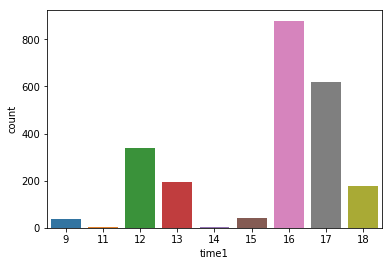

In [40]:
sns.countplot(train_df[train_df['target'] == 1]['time1'].apply(lambda t: t.hour));

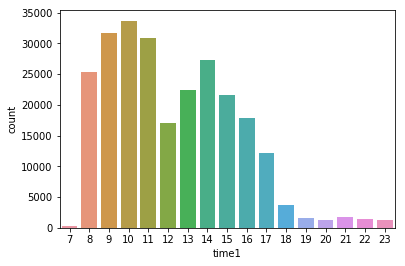

In [41]:
sns.countplot(train_df[train_df['target'] == 0]['time1'].apply(lambda t: t.hour));

In [42]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 9) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 8)).astype('int')
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)])
    feature_names = ["morning", "day", "evening", "night"]
    return X, feature_names

In [43]:
X_train_new, feature_names = add_time_features(train_df.fillna(0), X_train)
X_test_new, feature_names = add_time_features(test_df.fillna(0), X_test)
X_train_new.shape, X_test_new.shape

((253561, 50004), (82797, 50004))

### 5. Схема кросс валидации

In [44]:
time_split = TimeSeriesSplit(n_splits=10)

[(i[0][0], i[1].shape) for i in time_split.split(X_train)]
[(i[1][0], i[1][-1]) for i in time_split.split(X_train)]

[(23051, 46101),
 (46102, 69152),
 (69153, 92203),
 (92204, 115254),
 (115255, 138305),
 (138306, 161356),
 (161357, 184407),
 (184408, 207458),
 (207459, 230509),
 (230510, 253560)]

In [45]:
cv_scores = cross_val_score(model, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)
print(cv_scores, cv_scores.mean())

[0.871279   0.80228839 0.92892508 0.96592527 0.9155384  0.95171253
 0.95018805 0.93830256 0.9520421  0.95070422] 0.922690561556821


### 6. Подбор коэффицициента регуляризации

In [46]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=model, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [47]:
%%time
logit_grid_searcher.fit(X_train_new, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


Wall time: 1min 50s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=21, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [48]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9247433832119558, {'C': 1.6681005372000592})

**Обучим модель на всей выборке, сделаем прогноз для тестовой выборки и посылку в соревновании.**

In [49]:
# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [50]:
# Ваш код здесь
pred_proba = logit_grid_searcher.predict_proba(X_test_new)[:, 1]
write_to_submission_file(pred_proba, "sub.csv")